In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set(style="darkgrid")

atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Release"
sys.path.append(atlas_path)


from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy.ast import *

In [3]:
exchange_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/src/crypto exchange"
strategy_id = "test_strategy"
exchange_id = "test_exchange"
portfolio_id = "test_portfolio"

hydra = Hydra()
intial_cash = 100.0
exchange = hydra.addExchange(exchange_id, exchange_path, "")
portfolio = hydra.addPortfolio(portfolio_id, exchange, intial_cash)
hydra.build()

In [6]:
hydra.reset()
multiplier = 3
st = time.perf_counter_ns()
close = AssetReadNode.make("Close", 0, exchange)
previous_close = AssetReadNode.make("Close", -1, exchange)

atr_node = ATRNode.make(
    exchange,
    "High",
    "Low",
    14
) 
median_node = AssetMedianNode.make(
    exchange,
    "High",
    "Low",
)

# ===== Lower Band =====
lower_band = AssetOpNode.make(
    median_node,
    AssetScalerNode(atr_node, AssetOpType.MULTIPLY, multiplier),
    AssetOpType.SUBTRACT
)
lower_left_cond = AssetIfNode(
    lower_band,
    AssetCompType.GREATER,
    DummyNode(exchange)
)
lower_right_cond = AssetIfNode(
    previous_close,
    AssetCompType.LESS, 
    DummyNode(exchange)
)
final_lower_band = AssetCompNode(
    lower_left_cond,
    LogicalType.OR,
    lower_right_cond,
    lower_band,
    DummyNode(exchange)
)
lagged_final_lower_band = final_lower_band.lag(1)
lower_left_cond.swapRightEval(lagged_final_lower_band)
lower_right_cond.swapRightEval(lagged_final_lower_band)
final_lower_band.swapFalseEval(lagged_final_lower_band)
# ======================

# ===== Upper Band =====
upper_band = AssetOpNode.make(
    median_node,
    AssetScalerNode(atr_node, AssetOpType.MULTIPLY, multiplier),
    AssetOpType.ADD
)
upper_left_cond = AssetIfNode(
    upper_band,
    AssetCompType.LESS,
    DummyNode(exchange)
)
upper_right_cond = AssetIfNode(
    previous_close,
    AssetCompType.GREATER, 
    DummyNode(exchange)
)
final_upper_band = AssetCompNode(
    upper_left_cond,
    LogicalType.OR,
    upper_right_cond,
    upper_band,
    DummyNode(exchange)
)
lagged_final_upper_band = final_upper_band.lag(1)
upper_left_cond.swapRightEval(lagged_final_upper_band)
upper_right_cond.swapRightEval(lagged_final_upper_band)
final_upper_band.swapFalseEval(lagged_final_upper_band)
# ======================

exchange.enableNodeCache("final_lower_band",final_lower_band, False)
exchange.enableNodeCache("final_upper_band",final_upper_band, False)

spread_upper = AssetOpNode.make(close, final_upper_band, AssetOpType.SUBTRACT)
spread_lower = AssetOpNode.make(close, final_lower_band, AssetOpType.SUBTRACT)
spread_filter_up = ExchangeViewFilter(ExchangeViewFilterType.GREATER_THAN, 0.0, None)
spread_filter_down = ExchangeViewFilter(ExchangeViewFilterType.LESS_THAN, 0.0, None)
exchange_view_down = ExchangeViewNode.make(exchange, spread_lower, spread_filter_down)
exchange_view_up = ExchangeViewNode.make(exchange, spread_upper, spread_filter_up, exchange_view_down)
exchange.enableNodeCache("exchange_view_up",exchange_view_up, False)
allocation_signal = AllocationNode.make(
    exchange_view_up,
    AllocationType.CONDITIONAL_SPLIT,
    0.0,
    -1
)
strategy_node_signal = StrategyNode.make(allocation_signal, portfolio)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node_signal, 1.0), True)
strategy.enableTracerHistory(TracerType.NLV)
strategy.enableTracerHistory(TracerType.ORDERS_EAGER)
hydra.run()

et = time.perf_counter_ns()
print(f"Time to build: {(et-st)/1e6}ms")

Time to build: 4.1789ms


In [7]:
ticker = "BTC-USD"
asset_id = exchange.getAssetIndex(ticker)
path = os.path.join(exchange_path,f"{ticker}.csv")  
df = pd.read_csv(path)
df["final_upper_band"] = final_upper_band.cache()[asset_id]
df["final_lower_band"] = final_lower_band.cache()[asset_id]
df["ev"] =  exchange_view_up.cache()[0]
df["spread_lower"] = df["Close"] - df["final_lower_band"]

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.index = df.index.tz_localize(None)
df

,Open,High,Low,Close,Adj Close,Volume,final_upper_band,final_lower_band,ev,spread_lower
Date,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0.000000,0.000000,0.000000,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,0.000000,0.000000,0.000000,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,0.000000,0.000000,0.000000,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.000000,0.000000,0.000000,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,0.000000,0.000000,0.000000,398.821014
...,...,...,...,...,...,...,...,...,...,...
2023-10-20,28773.451172,30024.421875,28607.021484,29643.160156,29643.160156,21436979200,30231.342890,27269.305575,6.526642,2373.854581
2023-10-21,29677.050781,30218.609375,29483.230469,30010.917969,30010.917969,11691604992,30231.342890,27793.095202,6.526642,2217.822767
2023-10-22,29904.357422,30182.431641,29763.574219,29845.681641,29845.681641,9885239296,30231.342890,27972.410528,6.526642,1873.271113


In [8]:
orders = strategy.getTracer().getOrders()
orders = [o.to_dict() for o in orders]
df_orders = pd.DataFrame(orders)
df_orders["fill_time"] = pd.to_datetime(df_orders["fill_time"])
df_orders = df_orders[df_orders["asset_id"] == asset_id]
df_orders.set_index("fill_time", inplace=True)
df_orders.head(5)

,asset_id,strategy_id,quantity,fill_price
fill_time,,,,
2014-10-06,2,0,-0.090909,330.079010
2014-10-14,2,0,0.181818,400.869995
2014-11-02,2,0,-0.181818,325.891998
2014-11-13,2,0,0.181818,420.734985
2014-11-21,2,0,-0.181818,350.847992


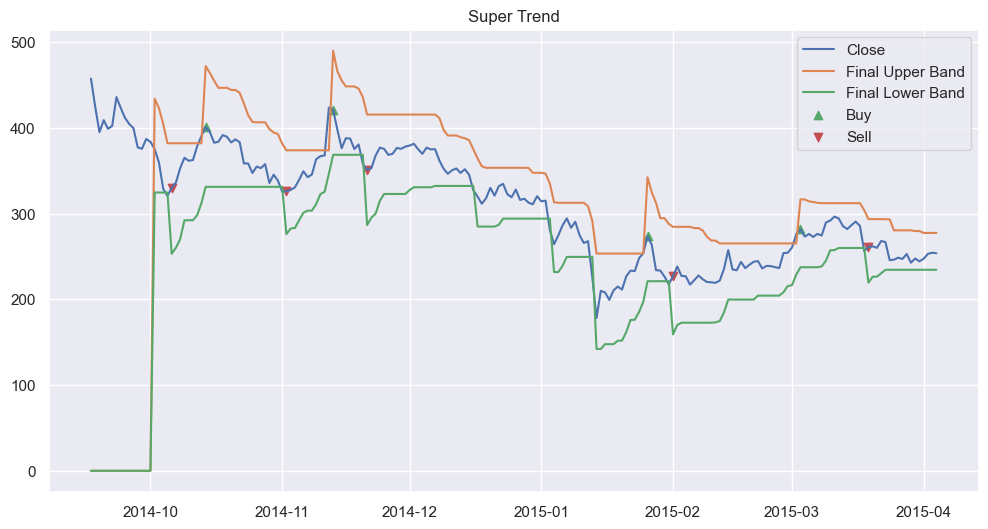

In [9]:
n = 200
df_sub = df.iloc[:n]
df_sub_max_time = df_sub.index.max()
df_orders_sub = df_orders[df_orders.index <= df_sub_max_time]

buys = df_orders_sub[df_orders_sub["quantity"] > 0]
sells = df_orders_sub[df_orders_sub["quantity"] < 0]

plt.figure(figsize=(12,6))
plt.plot(df_sub["Close"], label="Close")
plt.plot(df_sub["final_upper_band"], label="Final Upper Band")
plt.plot(df_sub["final_lower_band"], label="Final Lower Band")
plt.scatter(buys.index, buys["fill_price"], label="Buy", marker="^", color="g")
plt.scatter(sells.index, sells["fill_price"], label="Sell", marker="v", color="r")
plt.title("Super Trend")
plt.legend()
plt.show()

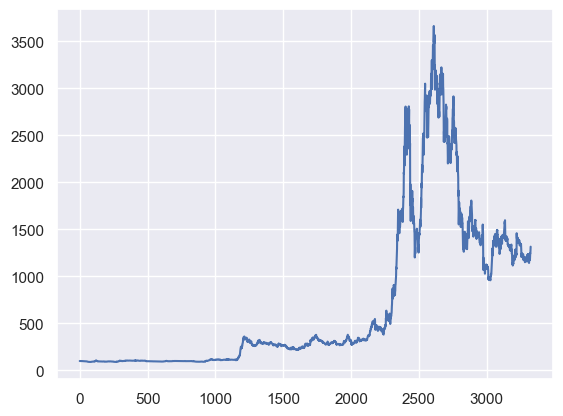

In [10]:
plt.plot(strategy.getHistory(TracerType.NLV))